### ECON 470 Homework 2-3
Author: Sarina Tan

In [20]:
pip install causalinference

  Obtaining dependency information for causalinference from https://files.pythonhosted.org/packages/dc/7f/4504b42ef5a1158075954f54d08b95b2d5b2186da0ef9fcbcd0cf31411f2/CausalInference-0.1.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 997.9 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from IPython.display import Markdown, display
import warnings
warnings.simplefilter('ignore')
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from causalinference import CausalModel
from scipy.spatial import distance
from scipy.spatial.distance import mahalanobis
from tabulate import tabulate

# Read output datasets
final_hcris_data = pd.read_csv('/Users/sarinatan/Desktop/HLTH470hw2/submission2/data-code/output/HCRIS_Data.csv')

 1. How many hospitals filed more than one report in the same year? Show your answer as a line graph of the number of hospitals over time.

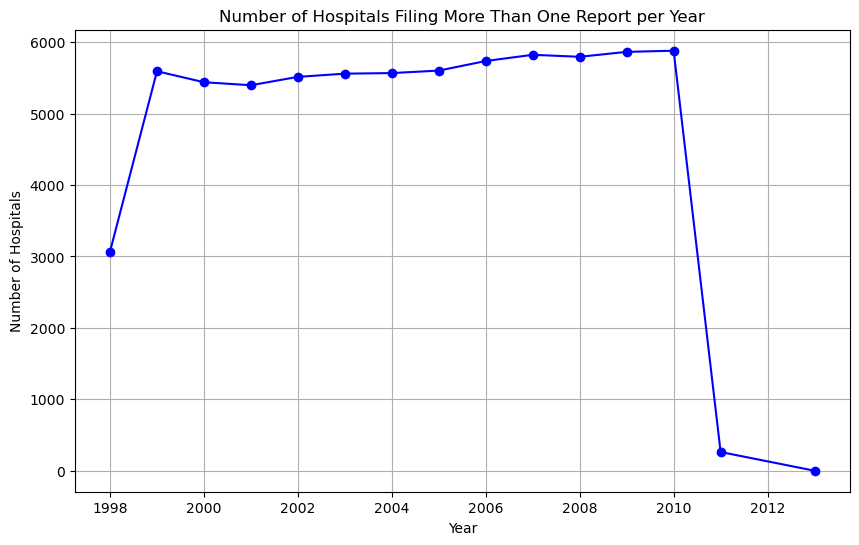

In [2]:
# Count the number of reports per hospital per year
report_counts = final_hcris_data.groupby(['year', 'provider_number']).size().reset_index(name='report_count')

# Filter hospitals that filed more than one report in the same year
multiple_reports = report_counts[report_counts['report_count'] > 1]

# Count the number of hospitals per year with multiple reports
hospitals_per_year = multiple_reports.groupby('year').size().reset_index(name='num_hospitals')

# Plot the result as a line graph
plt.figure(figsize=(10, 6))
plt.plot(hospitals_per_year['year'], hospitals_per_year['num_hospitals'], marker='o', linestyle='-', color='blue')
plt.title('Number of Hospitals Filing More Than One Report per Year')
plt.xlabel('Year')
plt.ylabel('Number of Hospitals')
plt.grid(True)
plt.show()

2. After removing/combining multiple reports, how many unique hospital IDs (Medicare provider numbers) exist in the data?

In [4]:

# Get the number of unique hospital IDs after combining multiple reports
unique_hospitals = final_hcris_data['provider_number'].nunique()
print(f'The number of unique hospital IDs is: {unique_hospitals}')

The number of unique hospital IDs is: 9323


 3. What is the distribution of total charges (tot_charges in the data) in each year? Show your results with a “violin” plot, with charges on the y-axis and years on the x-axis.

In [5]:
# Filter and preprocess data
charge_data = final_hcris_data.copy()

#Compute 1st and 99th percentile for total charges per year
charge_data['tot_charges_low'] = charge_data.groupby('year')['tot_charges'].transform(lambda x: np.nanpercentile(x,1))
charge_data['tot_charges_high'] = charge_data.groupby('year')['tot_charges'].transform(lambda x: np.nanpercentile(x,99))

#Filter out extreme values and missing data
charge_data = charge_data[
    (charge_data['tot_charges'] > charge_data['tot_charges_low']) &
    (charge_data['tot_charges'] < charge_data['tot_charges_high']) &
    charge_data['tot_charges'].notna() & 
    (charge_data['year'] > 1997)
]

#compute log of total charges
charge_data['log_charge'] = np.log(charge_data['tot_charges'])

#Prepare data for violin
years = sorted(charge_data['year'].unique())
data = [charge_data[charge_data['year'] == y]['log_charge'].dropna().values for y in years]

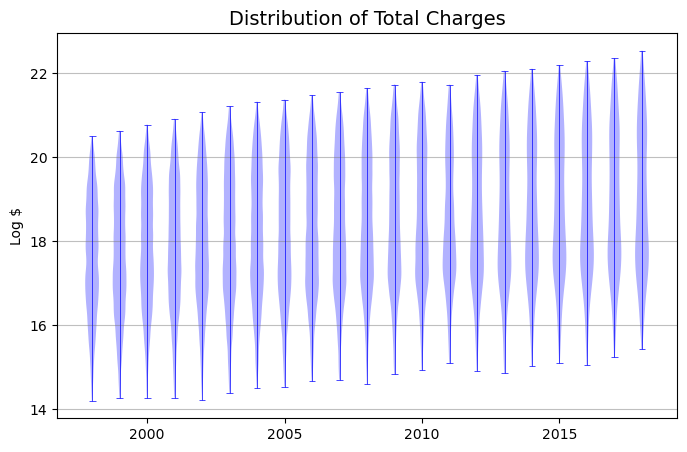

In [7]:
#plot distribution of total charges
fig, ax= plt.subplots(figsize = (8,5))
parts = ax.violinplot(data, positions= years, showmedians= False)

#customize violin plot 
for pc in parts ['bodies']:
    pc.set_facecolor('blue')
    pc.set_alpha (0.3)

for part in ['cbars','cmins', 'cmaxes']:
    parts[part].set_color('blue')
    parts[part].set_linewidth(0.5)

#format plot 
plt.title('Distribution of Total Charges', fontsize= 14)
plt. xlabel('')
plt.ylabel('Log \$')
plt. grid (axis = 'y', color = 'gray', linestyle = '-', alpha = 0.5)
plt.show()

4. What is the distribution of estimated prices in each year? Again present your results with a violin plot, and recall our formula for estimating prices from class. Be sure to do something about outliers and/or negative prices in the data.

In [9]:
#Compute price data
final_hcris_data['discount_factor'] = 1 - final_hcris_data['tot_discounts']/final_hcris_data['tot_charges']
final_hcris_data['price_num'] = (
    (final_hcris_data['ip_charges'] + final_hcris_data['icu_charges'] + final_hcris_data['ancillary_charges']) *
    final_hcris_data['discount_factor']
) - final_hcris_data ['tot_mcare_payment']
final_hcris_data['price_denom'] = final_hcris_data['tot_discharges'] - final_hcris_data['mcare_discharges']
final_hcris_data['price'] = final_hcris_data['price_num'] / final_hcris_data['price_denom']

#Data filtering
price_data = final_hcris_data[
    (final_hcris_data['price_denom'] > 100) &
    (~final_hcris_data['price_denom'].isna()) &
    (final_hcris_data['price_num'] > 0) &
    (~final_hcris_data['price_num'].isna()) &
    (final_hcris_data['price'] < 100000) &
    (final_hcris_data['beds'] > 30) &
    (~final_hcris_data['beds'].isna())
]

# Data preparation 
years= sorted(price_data['year'].unique())
data = [price_data[price_data['year'] == year]['price'].dropna().values for year in years]

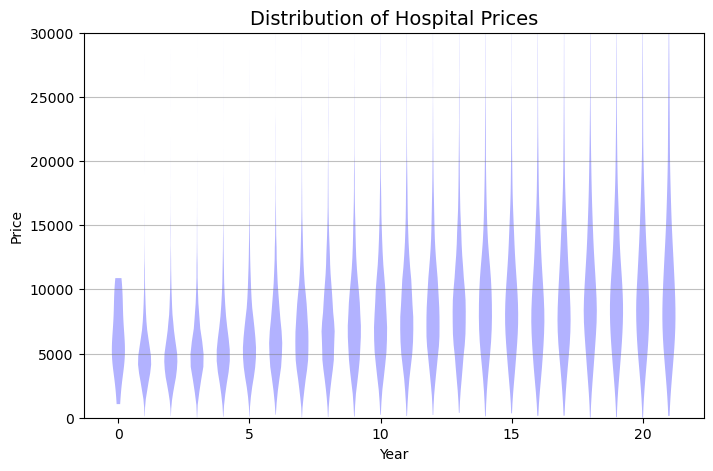

In [10]:
# Ensure data is formatted correctly
data = [np.array(arr) for arr in data if len(arr) > 0]  # Convert to arrays & remove empty ones
years = np.arange(len(data))  # Ensure x-axis matches number of datasets

# Only plot if data is valid
if len(data) > 0 and len(data) == len(years):
    fig, ax = plt.subplots(figsize=(8, 5))
    parts = ax.violinplot(data, positions=years, showmedians=False, showextrema=False)

    # Customize violin plot
    for pc in parts['bodies']:
        pc.set_facecolor('blue')
        pc.set_alpha(0.3)
        
    # Format plot
    plt.ylim(0, 30000)
    plt.title('Distribution of Hospital Prices', fontsize=14)
    plt.xlabel('Year')
    plt.ylabel('Price')
    plt.grid(axis='y', color='gray', linestyle='-', alpha=0.5)
    plt.show()
else:
    print("Error: Data and years length mismatch!")

5. Calculate the average price among penalized versus non-penalized hospitals.

In [12]:
# Filter for 2012
df_2012 = final_hcris_data[final_hcris_data['year'] == 2012]

# Define penalty as whether the sum of HRRP and HVBP amounts is negative
df_2012['penalty'] = (df_2012['hrrp_payment'] + df_2012['hvbp_payment']) < 0

# Calculate estimated prices
df_2012['discount_factor'] = 1 - (df_2012['tot_discounts'] / df_2012['tot_charges'])
df_2012['price_num'] = (df_2012['ip_charges'] + df_2012['icu_charges'] + 
                        df_2012['ancillary_charges']) * df_2012['discount_factor'] - df_2012['tot_mcare_payment']
df_2012['price_denom'] = df_2012['tot_discharges'] - df_2012['mcare_discharges']
df_2012['estimated_price'] = df_2012['price_num'] / df_2012['price_denom']

# Remove negative prices and extreme outliers
df_cleaned = df_2012[(df_2012['estimated_price'] > 0) & 
                     (df_2012['estimated_price'] < df_2012['estimated_price'].quantile(0.99))]

# Calculate average price among penalized vs non-penalized hospitals
avg_price_penalty = df_cleaned.groupby('penalty')['estimated_price'].mean()

print(avg_price_penalty)

penalty
False    9386.853470
True     9914.349854
Name: estimated_price, dtype: float64


6. Split hospitals into quartiles based on bed size. To do this, create 4 new indicator variables, where each variable is set to 1 if the hospital’s bed size falls into the relevant quartile. Provide a table of the average price among treated/control groups for each quartile.

In [13]:
# Calculate estimated prices
df_2012['discount_factor'] = 1 - (df_2012['tot_discounts'] / df_2012['tot_charges'])
df_2012['price_num'] = (df_2012['ip_charges'] + df_2012['icu_charges'] + 
                        df_2012['ancillary_charges']) * df_2012['discount_factor'] - df_2012['tot_mcare_payment']
df_2012['price_denom'] = df_2012['tot_discharges'] - df_2012['mcare_discharges']
df_2012['estimated_price'] = df_2012['price_num'] / df_2012['price_denom']

# Remove negative prices and extreme outliers
df_cleaned = df_2012[(df_2012['estimated_price'] > 0) & 
                     (df_2012['estimated_price'] < df_2012['estimated_price'].quantile(0.99))]

# Drop rows with NaN bed values before calculating quartiles
df_cleaned = df_cleaned.dropna(subset=['beds'])

# Split hospitals into quartiles based on bed size
df_cleaned['bed_quartile'] = pd.qcut(df_cleaned['beds'], q=4, labels=[1, 2, 3, 4])

# Create indicator variables for each quartile
df_cleaned['Q1'] = (df_cleaned['bed_quartile'] == 1).astype(int)
df_cleaned['Q2'] = (df_cleaned['bed_quartile'] == 2).astype(int)
df_cleaned['Q3'] = (df_cleaned['bed_quartile'] == 3).astype(int)
df_cleaned['Q4'] = (df_cleaned['bed_quartile'] == 4).astype(int)

# Calculate the average price among treated/control groups for each quartile
result = df_cleaned.groupby(['bed_quartile', 'penalty'])['estimated_price'].mean().unstack()


In [14]:
# Compute the average price by treatment status (penalized vs. non-penalized) and quartile
quartile_avg_price = df_cleaned.groupby(['bed_quartile', 'penalty'])['estimated_price'].mean().unstack()

# Rename columns for clarity
quartile_avg_price.columns = ['Control (No Penalty)', 'Treated (Penalty)']
quartile_avg_price.index.name = 'Bed Quartile'
quartile_avg_price = quartile_avg_price.round(2)

# Display the final table
print("\nTable: Average Price by Treatment Status for Each Bed Size Quartile\n")
quartile_avg_price



Table: Average Price by Treatment Status for Each Bed Size Quartile



,Control (No Penalty),Treated (Penalty)
Bed Quartile,,
1,7604.58,6611.76
2,8376.98,8965.53
3,9679.02,10554.51
4,11916.12,12435.12


7. Find the average treatment effect using each of the following estimators, and present your results in a single table: 

- Nearest neighbor matching (1-to-1) with inverse variance distance based on quartiles of bed size
- Nearest neighbor matching (1-to-1) with Mahalanobis distance based on quartiles of bed size
- Inverse propensity weighting, where the propensity scores are based on quartiles of bed size
- Simple linear regression, adjusting for quartiles of bed size using dummy variables and appropriate interactions as discussed in class

In [24]:
# Create Bed Quartile Dummies for Covariates
bed_quarts = pd.get_dummies(df_cleaned['bed_quartile'], prefix='bed_quart').iloc[:, :-1] * 1
bed_quarts = bed_quarts.sub(bed_quarts.mean(axis=0), axis=1)  # Standardizing covariates

# Ensure Treatment Variable is Binary 
df_cleaned['penalty'] = df_cleaned['penalty'].astype(int)  # Convert to integer (0 or 1)

# Extract Variables for Causal Model
treatment = df_cleaned['penalty'].values  # Binary treatment variable
outcome = df_cleaned['price'].values  # Outcome variable (hospital price)
covariates = bed_quarts.values  # Covariates (bed quartiles) as NumPy matrix

# Initialize the Causal Model
cm = CausalModel(Y=outcome, D=treatment, X=covariates)

print(cm)  

# Estimate Treatment Effects 
results = pd.DataFrame(index=['ATE', 'SE'], columns=['NN-INV', 'NN-MAH', 'IPW', 'OLS'])

# Nearest Neighbor Matching with Inverse Variance Distance
cm.est_via_matching(weights='inv', matches=1, bias_adj=True)
results.loc['ATE', 'NN-INV'] = cm.estimates['matching']['ate']
results.loc['SE', 'NN-INV'] = cm.estimates['matching']['ate_se']

# Nearest Neighbor Matching with Mahalanobis Distance
cm.est_via_matching(weights='maha', matches=1, bias_adj=True)
results.loc['ATE', 'NN-MAH'] = cm.estimates['matching']['ate']
results.loc['SE', 'NN-MAH'] = cm.estimates['matching']['ate_se']

# Inverse Propensity Weighting
cm.est_propensity()  # Estimate propensity scores
cm.est_via_weighting()
results.loc['ATE', 'IPW'] = cm.estimates['weighting']['ate']
results.loc['SE', 'IPW'] = cm.estimates['weighting']['ate_se']

# OLS Regression, adjusting for bed quartiles using dummy variables & interactions
cm.est_via_ols(adj=2)  # `adj=2` means it includes covariates + interactions
results.loc['ATE', 'OLS'] = cm.estimates['ols']['ate']
results.loc['SE', 'OLS'] = cm.estimates['ols']['ate_se']

# Convert DataFrame to Markdown format using tabulate
markdown_table = tabulate(results, headers="keys", tablefmt="github")

# Display as Markdown
display(Markdown("### **Average Treatment Effect Estimates**"))
display(Markdown(f"```\n{markdown_table}\n```"))
display(Markdown(results.to_markdown()))

### **Average Treatment Effect Estimates**

```
|     |   NN-INV |   NN-MAH |     IPW |     OLS |
|-----|----------|----------|---------|---------|
| ATE |  246.915 |  246.915 | 246.915 | 246.915 |
| SE  |  493.912 |  493.912 | 444.988 | 444.769 |
```

|     |   NN-INV |   NN-MAH |     IPW |     OLS |
|:----|---------:|---------:|--------:|--------:|
| ATE |  246.915 |  246.915 | 246.915 | 246.915 |
| SE  |  493.912 |  493.912 | 444.988 | 444.769 |

8. With these different treatment effect estimators, are the results similar, identical, very different?

With these different treatment effect estimators, the results of the average treatment effect (ATE) were the same for all four estimators. The standard error across the four estimators slightly vary, but are still close. Nearest neighbor matching with inverse variance and nearest neighbor matching with Mahalanobis distance resulted in the same average treatment effect and standard error. 


9. Do you think you’ve estimated a causal effect of the penalty? Why or why not? (just a couple of sentences)

Overall, I do not think I have estimated a causal effect of the penalty. Hospitals receiving penalties may differ systematically from those that do not. Even though matching and regression techniques to control for bed size were used, unobserved confounders could still bias the results. A more rigorous causal analysis would probably require an instrumental variable or a randomized design.

10. Briefly describe your experience working with these data (just a few sentences). Tell me one thing you learned and one thing that really aggravated or surprised you.

 My experience working with this data was a bit frustrating. The data took a long time to load onto my laptop as well as processing to make the new cleaned csv files. One thing that I learned is that with a lot of data, there are also a lot of blanks that need to be filled in and/or removed while merging files together. While I was able to make the final HCRIS data pretty smoothly, it was aggravating to then see that there were still blanks and spots that said NaN that made me unable to analyze it. 